In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')

def get_simulation_parameters(ticker, start_date='2020-01-01'):
    """
    Robustly downloads data and calculates annualized mu and sigma.
    """
    print(f"Downloading data for {ticker}...")
    
    # auto_adjust=True ensures we get the 'real' price (accounting for splits/dividends)
    # and usually simplifies the columns to just [Open, High, Low, Close, Volume]
    data = yf.download(ticker, start=start_date, progress=False, auto_adjust=True)
    
    # --- DATA CLEANING BLOCK ---
    if data.empty:
        raise ValueError(f"No data found for {ticker}. Check your internet or ticker symbol.")

    # Flatten MultiIndex columns if they exist (e.g., ('Close', 'NVDA') -> 'Close')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Try to grab the closing price
    if 'Close' in data.columns:
        prices = data['Close']
    elif 'Adj Close' in data.columns:
        prices = data['Adj Close']
    else:
        # Fallback: Just take the first column if "Close" is missing
        print(f"Warning: 'Close' column not found. Using {data.columns[0]} instead.")
        prices = data.iloc[:, 0]
    # ---------------------------

    # 2. Calculate Log Returns
    log_returns = np.log(prices / prices.shift(1)).dropna()

    # 3. Calculate Annualized Parameters
    sigma = log_returns.std() * np.sqrt(252)
    mu = log_returns.mean() * 252
    s0 = prices.iloc[-1] 

    print(f"--- Parameters for {ticker} ---")
    print(f"Start Price (S0): ${s0:.2f}")
    print(f"Annualized Volatility (sigma): {sigma:.2%}")
    print(f"Annualized Drift (mu): {mu:.2%}")
    
    return s0, mu, sigma

S0, mu, sigma = get_simulation_parameters('NVDA')

--- Parameters for NVDA ---
Start Price (S0): $183.32
Annualized Volatility (sigma): 52.75%
Annualized Drift (mu): 56.77%


In [3]:
def simulate_gbm(S0, mu, sigma, T, N, M):
    """
    Simulates Geometric Brownian Motion (GBM) paths.
    
    Parameters:
    S0    : Initial stock price
    mu    : Annualized drift (expected return)
    sigma : Annualized volatility
    T     : Time horizon in years
    N     : Number of time steps (e.g., 252 for daily)
    M     : Number of simulations (paths)
    
    Returns:
    pd.DataFrame of price paths (shape: N+1 rows, M columns)
    """
    # 1. Time step size (dt)
    dt = T / N
    
    # 2. Simulate the random component (Brownian Motion)
    # Generate M paths with N steps each
    Z = np.random.normal(0, 1, size=(N, M))
    
    # 3. Calculate the Drift and Diffusion terms
    # Drift: Deterministic trend based on mu
    drift = (mu - 0.5 * sigma**2) * dt
    
    # Diffusion: Random shock scaled by volatility
    diffusion = sigma * np.sqrt(dt) * Z
    
    # 4. Calculate Daily Returns
    daily_returns = np.exp(drift + diffusion)
    
    # 5. Accumulate Returns to get Prices
    # Initialize price matrix
    price_paths = np.zeros((N + 1, M))
    price_paths[0] = S0
    
    # Cumulative product to compound returns
    price_paths[1:] = S0 * np.cumprod(daily_returns, axis=0)
    
    return pd.DataFrame(price_paths)

print("GBM Engine loaded successfully.")

GBM Engine loaded successfully.


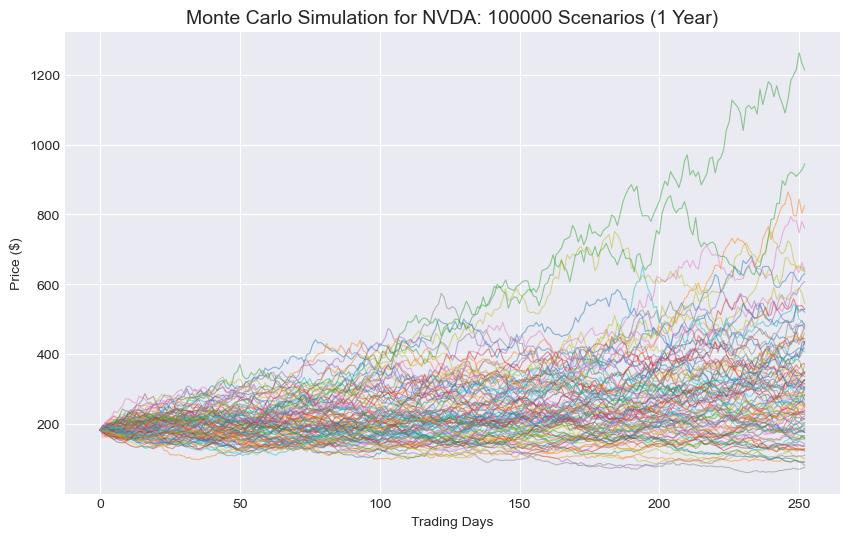

In [8]:
# Simulation Settings
T = 1.0       # Time horizon: 1 Year
N = 252       # Time steps: 252 trading days
M = 100000     # Number of paths: 10,000

# Run the simulation using the parameters from Cell 1
price_paths = simulate_gbm(S0, mu, sigma, T, N, M)

# Visualization
plt.figure(figsize=(10, 6))
# We only plot the first 100 paths to keep the chart clean
plt.plot(price_paths.iloc[:, :100], alpha=0.5, linewidth=0.8)

plt.title(f"Monte Carlo Simulation for NVDA: {M} Scenarios (1 Year)", fontsize=14)
plt.xlabel("Trading Days")
plt.ylabel("Price ($)")
plt.show()

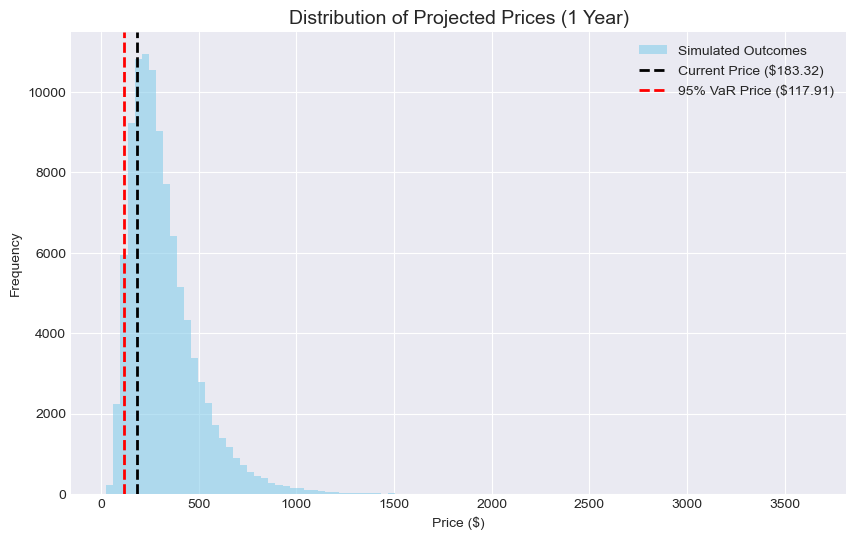

--- Risk Analysis Report for NVDA ---
Current Price: $183.32
95% Worst Case Price (1 Year): $117.91
Value at Risk ($): $65.41
Value at Risk (%): 35.68%


In [9]:
# 1. Get the prices at the end of the year (the last row)
terminal_prices = price_paths.iloc[-1]

# 2. Calculate the 95% VaR (The 5th percentile worst outcome)
# This means: "95% of the time, the price will be ABOVE this number"
confidence_level = 0.95
future_price_95 = np.percentile(terminal_prices, (1 - confidence_level) * 100)

# Calculate the actual loss amount from today's price
VaR_amount = S0 - future_price_95

# 3. Plot the Histogram of Final Prices
plt.figure(figsize=(10, 6))
plt.hist(terminal_prices, bins=100, alpha=0.6, color='skyblue', label='Simulated Outcomes')

# Add lines for Today's Price and the VaR Threshold
plt.axvline(S0, color='black', linestyle='--', linewidth=2, label=f'Current Price (${S0:.2f})')
plt.axvline(future_price_95, color='red', linestyle='--', linewidth=2, label=f'95% VaR Price (${future_price_95:.2f})')

plt.title("Distribution of Projected Prices (1 Year)", fontsize=14)
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 4. Print the Risk Report
print(f"--- Risk Analysis Report for NVDA ---")
print(f"Current Price: ${S0:.2f}")
print(f"95% Worst Case Price (1 Year): ${future_price_95:.2f}")
print(f"Value at Risk ($): ${VaR_amount:.2f}")
print(f"Value at Risk (%): {(VaR_amount/S0)*100:.2f}%")

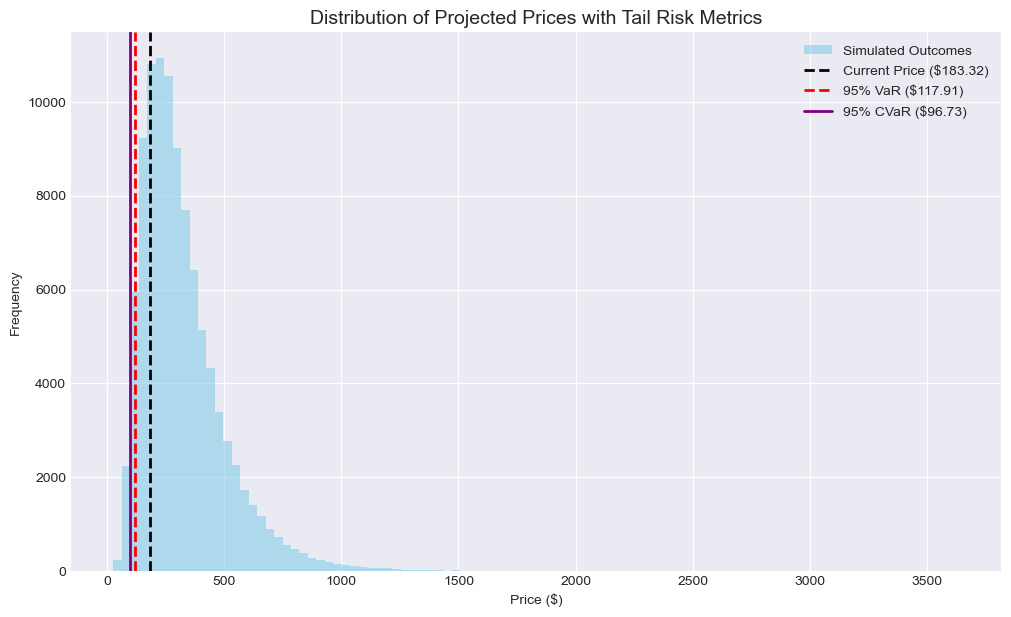

--- Advanced Risk Metrics for Asset ---
Confidence Level: 95%
----------------------------------------
Value at Risk (VaR):        $65.41  (The threshold of the worst 5%)
Expected Shortfall (CVaR):  $86.59  (The average loss IF we breach the threshold)
----------------------------------------
Interpretation: With 95% confidence, we won't lose more than $65.41.
However, if a crash DOES occur, we expect to lose around $86.59.


In [10]:
# 1. Calculate Conditional Value at Risk (CVaR) / Expected Shortfall
# Logic: Take all scenarios WORSE than the VaR threshold, and average them.
worst_outcomes = terminal_prices[terminal_prices <= future_price_95]
CVaR_price = worst_outcomes.mean()

# Calculate the loss amount
CVaR_loss = S0 - CVaR_price

# 2. Updated Plot with CVaR
plt.figure(figsize=(12, 7))
plt.hist(terminal_prices, bins=100, alpha=0.6, color='skyblue', label='Simulated Outcomes')

# Add lines
plt.axvline(S0, color='black', linestyle='--', linewidth=2, label=f'Current Price (${S0:.2f})')
plt.axvline(future_price_95, color='red', linestyle='--', linewidth=2, label=f'95% VaR (${future_price_95:.2f})')
plt.axvline(CVaR_price, color='purple', linestyle='-', linewidth=2, label=f'95% CVaR (${CVaR_price:.2f})')

plt.title("Distribution of Projected Prices with Tail Risk Metrics", fontsize=14)
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 3. Final Professional Report
print(f"--- Advanced Risk Metrics for {ticker if 'ticker' in globals() else 'Asset'} ---")
print(f"Confidence Level: {confidence_level:.0%}")
print("-" * 40)
print(f"Value at Risk (VaR):        ${VaR_amount:.2f}  (The threshold of the worst 5%)")
print(f"Expected Shortfall (CVaR):  ${CVaR_loss:.2f}  (The average loss IF we breach the threshold)")
print("-" * 40)
print(f"Interpretation: With 95% confidence, we won't lose more than ${VaR_amount:.2f}.")
print(f"However, if a crash DOES occur, we expect to lose around ${CVaR_loss:.2f}.")

In [11]:
from scipy.stats import norm

# 1. Calculate the Theoretical (Parametric) VaR
# We use the inverse cumulative distribution function (ppf) to find the Z-score
# For 95% confidence, we want the bottom 5% cutoff (approx -1.645)
z_score = norm.ppf(1 - confidence_level) 

# Calculate the theoretical price at that cutoff using the GBM formula directly:
# S_t = S0 * exp( (mu - 0.5*sigma^2)*t + sigma*sqrt(t)*Z )
parametric_price = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_score)

# Calculate the loss amount
parametric_VaR = S0 - parametric_price

# 2. Compare the Results
print(f"--- Methodology Comparison (Validation) ---")
print(f"Monte Carlo VaR (Simulation): ${VaR_amount:.2f}")
print(f"Parametric VaR (Theory):      ${parametric_VaR:.2f}")
print("-" * 40)

difference = abs(VaR_amount - parametric_VaR)
print(f"Difference: ${difference:.2f} ({difference/parametric_VaR:.2%} error)")

if difference/parametric_VaR < 0.02:
    print("✅ SUCCESS: Simulation is highly accurate (<2% deviation).")
else:
    print("⚠️ NOTE: Discrepancy detected. Try increasing M (simulations) to 50,000 for better convergence.")

--- Methodology Comparison (Validation) ---
Monte Carlo VaR (Simulation): $65.41
Parametric VaR (Theory):      $65.16
----------------------------------------
Difference: $0.26 (0.40% error)
✅ SUCCESS: Simulation is highly accurate (<2% deviation).
